https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md # medium model, including word vectors (word embeddings) 
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from operator import itemgetter


In [2]:
# DF
df = pd.read_csv("C:\\Users\\Katharina\\Documents\\Uni\\6_WS2223\\Masterarbeit\\code\\WomenInEP\\data\\csv\\Roe_v_Wade.csv", index_col=0)
# Show dataframe
df.head()

,debate_id,date,speaker,text,text_translated,language,country,EU political group,national political group,nationalty,gender,birth_year,birth_place,political_groups,national_parties,abortion,women_rights,Roe_v_Wade,debate_year,age_atDebate
164589,20161005.EN,2016-10-05,Zdzisław Krasnodębski,"Ja może zacznę od odpowiedzi, bo pani in 't V...","Maybe I'll start with the answer, because Mrs....",pl,Poland,European Conservatives and Reformists Group,Prawo i Sprawiedliwość,Poland,M,1953,Choszczno,01-07-2014 / 28-02-2018 : European Conservativ...,01-07-2014 / 01-07-2019 : Bezpartyjny (Poland)...,1,1,1,2016,63
190125,20170214.EN,2017-02-14,Anna Záborská,písomne. – Únia musí pripraviť na odchod Veľk...,in writing.- The Union must prepare for the de...,sk,NaN,NaN,NaN,Slovakia,F,1948,Zürich,30-04-2003 / 30-04-2004 : Group of the Europea...,01-05-2004 / 19-07-2004 : Kresťanskodemokratic...,1,0,1,2017,69
192065,20170314.EN,2017-03-14,Branislav Škripek,blue-card answer. – I do not know if I will m...,blue-card answer. – I do not know if I will ma...,en,NaN,NaN,NaN,Slovakia,M,1970,Piešťany,01-07-2014 / 29-01-2015 : European Conservativ...,01-07-2014 / 01-07-2019 : OBYCAJNÍ LUDIA (Slov...,1,0,1,2017,47
192068,20170314.EN,2017-03-14,Malin Björk,för GUE/NGL-gruppen. – Herr talman! Varje rep...,for the GUE/NGL group.- Mr. President!Every Re...,sv,Sweden,The Left group in the European Parliament - GU...,Vänsterpartiet,Sweden,F,1972,Göteborg,01-07-2014 / 11-01-2017 : Confederal Group of ...,01-07-2014 / 01-07-2019 : Vänsterpartiet (Swed...,1,1,1,2017,45
211199,20180502.EN,2018-05-02,Roberta Metsola,"Mr President, the situation we are facing wit...","Mr President, the situation we are facing with...",en,Malta,Group of the European People's Party (Christia...,Partit Nazzjonalista,Malta,F,1979,St Julians,25-04-2013 / 30-06-2014 : Group of the Europea...,25-04-2013 / 30-06-2014 : Partit Nazzjonalista...,1,0,1,2018,39


In [3]:
df_original = df # as a backup

### topic modeling

In [14]:
# stopwords = en.Defaults.stop_words

In [7]:
# if using full debates: MemoryError: Unable to allocate 6.06 GiB for an array with shape (16956926, 96) and data type float32

# Our spaCy model:
# English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for text in nlp.pipe(df['text_translated']):
   proj_tok = [token.lemma_.lower() for token in text if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [16]:
#nlp.analyze_pipes()

In [8]:
df['tokens'] = tokens
df['tokens']

164589    [start, answer, t, veld, answer, question, let...
190125    [union, prepare, departure, uk, mean, budget, ...
192065    [blue, card, answer, know, manage, question, s...
192068    [gue, ngl, republican, presidential, administr...
211199    [mr, president, situation, face, migrant, chil...
249176    [mr, president, dear, colleague, thing, preven...
260240    [madam, president, today, mean, opinion, breac...
261857    [madam, president, wow, headline, resolution, ...
261861    [madam, president, vice, president, colleague,...
261868    [madam, president, look, room, man, include, c...
261905    [madam, president, lively, debate, think, even...
261917    [madam, president, roe, wade, pivotal, ruling,...
261919    [madam, president, criminalise, abortion, crim...
261920    [madam, president, wonder, year, history, peop...
261927    [deal, sad, debate, prove, clash, civilization...
262629    [prevent, abortion, point, forbid, secure, leg...
262645    [madam, president, vicious, di

In [9]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [10]:
dictionary.token2id

{'abortion': 0,
 'age': 1,
 'answer': 2,
 'autonomy': 3,
 'base': 4,
 'break': 5,
 'case': 6,
 'check': 7,
 'chici': 8,
 'choice': 9,
 'conduct': 10,
 'conflict': 11,
 'debate': 12,
 'democratic': 13,
 'difficult': 14,
 'discussion': 15,
 'dramatic': 16,
 'europe': 17,
 'exist': 18,
 'follow': 19,
 'free': 20,
 'human': 21,
 'issue': 22,
 'know': 23,
 'lack': 24,
 'legal': 25,
 'let': 26,
 'life': 27,
 'long': 28,
 'majority': 29,
 'matter': 30,
 'moral': 31,
 'movement': 32,
 'opinion': 33,
 'person': 34,
 'poland': 35,
 'polish': 36,
 'position': 37,
 'practice': 38,
 'pregnancy': 39,
 'principle': 40,
 'pro': 41,
 'problem': 42,
 'question': 43,
 'recognize': 44,
 'remember': 45,
 'remind': 46,
 'remove': 47,
 'respect': 48,
 'result': 49,
 'right': 50,
 'rule': 51,
 'say': 52,
 'sex': 53,
 'show': 54,
 'society': 55,
 'solution': 56,
 'start': 57,
 'state': 58,
 't': 59,
 'take': 60,
 'talk': 61,
 'time': 62,
 'today': 63,
 'tooth': 64,
 'totalitarian': 65,
 'underway': 66,
 'veld'

In [11]:
# below = appearance in less than 5 documents, above = in more than 50% of all documents; keep n= keep 1000 most frequent tokens after filtering
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [12]:
# occurance of words per document(row of df)
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [13]:
#corpus

In [14]:
# Latent Dirichlet Allocation
# workers: find the number of cores on your PC by pressing the ctr+shift+esc keys - I have 2
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 2, passes=10)

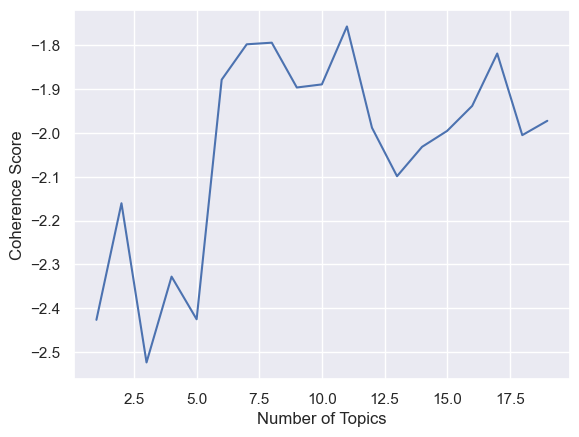

In [15]:
#Calculating the coherence score using C_umass:
topics = []
score = []

for i in range(1,20,1):   
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)   
    
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')   
    
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

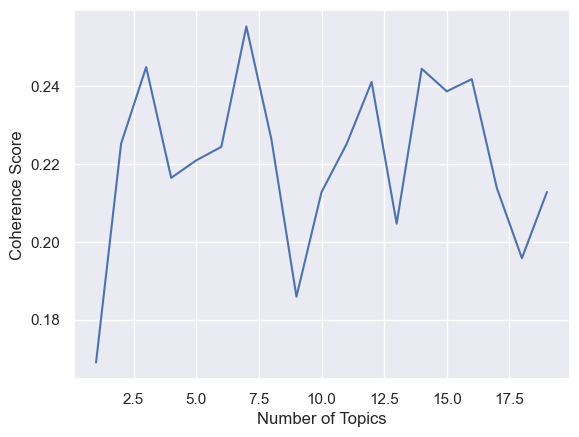

In [16]:
#Calculating the coherence score using C_v:
topics = []
score = []

for i in range(1,20,1):   
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)   
    
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
    
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [18]:
# check  C_umass or C_v graphs for deciding number of topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=7, workers = 2, passes=100)

In [19]:
# printing out the (9) topics and related words; -1 ordered by significance
# interesting topic including women: -1-
lda_model.print_topics(-1)

[(0,
  '0.151*"health" + 0.116*"sexual" + 0.114*"reproductive" + 0.107*"mean" + 0.060*"parliament" + 0.058*"want" + 0.045*"access" + 0.041*"body" + 0.038*"fight" + 0.037*"states"'),
 (1,
  '0.096*"state" + 0.081*"legal" + 0.081*"choice" + 0.075*"world" + 0.065*"know" + 0.065*"europe" + 0.065*"talk" + 0.049*"pro" + 0.049*"safe" + 0.042*"human"'),
 (2,
  '0.160*"fundamental" + 0.101*"member" + 0.090*"states" + 0.083*"colleague" + 0.083*"let" + 0.052*"ban" + 0.046*"europe" + 0.044*"say" + 0.044*"today" + 0.044*"fight"'),
 (3,
  '0.080*"europe" + 0.069*"year" + 0.069*"human" + 0.067*"ban" + 0.059*"health" + 0.058*"decision" + 0.058*"safe" + 0.058*"stand" + 0.047*"states" + 0.047*"state"'),
 (4,
  '0.117*"let" + 0.081*"choice" + 0.071*"say" + 0.071*"european" + 0.071*"fundamental" + 0.052*"health" + 0.049*"pro" + 0.045*"today" + 0.041*"legal" + 0.035*"access"'),
 (5,
  '0.192*"let" + 0.161*"body" + 0.098*"ban" + 0.067*"pro" + 0.036*"value" + 0.036*"know" + 0.036*"fight" + 0.036*"talk" + 0.0

In [20]:
lda_model.print_topic(3)

'0.080*"europe" + 0.069*"year" + 0.069*"human" + 0.067*"ban" + 0.059*"health" + 0.058*"decision" + 0.058*"safe" + 0.058*"stand" + 0.047*"states" + 0.047*"state"'

In [22]:
df['text_translated'][190125]

'in writing.- The Union must prepare for the departure of the UK, which will mean a budget failure, economic shocks or a change in political balance in decision -making.It is also an opportunity to evaluate where the EU works well, where it has reserves and shortcomings and in which areas it fails.Again, the so -called.Two -speed Europe - that is, the fact that states that want to continue deeper integration should not wait for those who are satisfied with the degree of cooperation.Member States that do not join the core will gradually find themselves on the edge of the events, with a small impact on political decision -making.Those who would like the law to protect every human life and respect the reservation of conscience are now in a minority in Slovakia and Europe.And being in a minority in democracy means risking that most adopt laws that will not allow us to obey.If Slovakia joins the core of Europe, Christians and Pro-Life Movement activists will be exposed to strong pressure to

In [25]:
# the above text shall belong to the following topics:
lda_model[corpus][1]

[(3, 0.94263726)]

In [26]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\Katharina\anaconda3\envs\MA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [27]:
# add column to df with most probable topic
df['topic'] = [sorted(lda_model[corpus][text], key=itemgetter(1), reverse=True)[0][0] for text in range(len(df['text_translated']))]

In [28]:
# frequency of each topic:
df.topic.value_counts()

3    5
1    4
5    2
0    2
4    2
6    2
2    1
Name: topic, dtype: int64

In [46]:
# extract interventions where topics are women related

In [29]:
#df -----------------------------------------------------------------------------------CHANGES NEEDED?

,debate_id,date,speaker,text,text_translated,language,country,EU political group,national political group,tokens,topic
164589,20161005.EN,2016-10-05,Zdzisław Krasnodębski,"Ja może zacznę od odpowiedzi, bo pani in 't V...","Maybe I'll start with the answer, because Mrs....",pl,Poland,European Conservatives and Reformists Group,Prawo i Sprawiedliwość,"[start, answer, t, veld, answer, question, let...",1
190125,20170214.EN,2017-02-14,Anna Záborská,písomne. – Únia musí pripraviť na odchod Veľk...,in writing.- The Union must prepare for the de...,sk,NaN,NaN,NaN,"[union, prepare, departure, uk, mean, budget, ...",3
192065,20170314.EN,2017-03-14,Branislav Škripek,blue-card answer. – I do not know if I will m...,blue-card answer. – I do not know if I will ma...,en,NaN,NaN,NaN,"[blue, card, answer, know, manage, question, s...",5
192068,20170314.EN,2017-03-14,Malin Björk,för GUE/NGL-gruppen. – Herr talman! Varje rep...,for the GUE/NGL group.- Mr. President!Every Re...,sv,Sweden,The Left group in the European Parliament - GU...,Vänsterpartiet,"[gue, ngl, republican, presidential, administr...",0
211199,20180502.EN,2018-05-02,Roberta Metsola,"Mr President, the situation we are facing wit...","Mr President, the situation we are facing with...",en,Malta,Group of the European People's Party (Christia...,Partit Nazzjonalista,"[mr, president, situation, face, migrant, chil...",4
249176,20210623.EN,2021-06-23,Terry Reintke,"Mr President, dear colleagues, I only have th...","Mr President, dear colleagues, I only have thr...",en,Germany,Group of the Greens/European Free Alliance,Bündnis 90/Die Grünen,"[mr, president, dear, colleague, thing, preven...",6
260240,20220504.EN,2022-05-04,Samira Rafaela,"Madam President, today I was meant to give my...","Madam President, today I was meant to give my ...",en,Netherlands,Renew Europe Group,Democraten 66,"[madam, president, today, mean, opinion, breac...",0
261857,20220608.EN,2022-06-08,Christine Anderson,"Madam President, wow, the headline of this re...","Madam President, wow, the headline of this res...",en,Germany,Identity and Democracy Group,Alternative für Deutschland,"[madam, president, wow, headline, resolution, ...",1
261861,20220608.EN,2022-06-08,Frances Fitzgerald,"Madam President, Vice-President, colleagues, ...","Madam President, Vice-President, colleagues, w...",en,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,"[madam, president, vice, president, colleague,...",3
261868,20220608.EN,2022-06-08,Nicolae Ştefănuță (Renew,"Madam President, I’m looking around the room ...","Madam President, I’m looking around the room a...",en,Romania,Renew Europe Group,Uniunea Salvați România,"[madam, president, look, room, man, include, c...",5


In [32]:
#df1 = df.drop('national political group', axis=1)
df.to_csv('Roe_v_Wade_tokenized.csv')